In [1]:

from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../../AICity_data/train/S03/c010/'

In [2]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 535) # 514 is the 25% of the frames

100%|██████████| 534/534 [00:07<00:00, 73.61it/s]


In [3]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

In [4]:
print(np.min(means),np.max(means))

0.0 251.18878504672898


In [7]:
singleGaussianDetections = remove_background_adaptative(means,stds, data_path + 'vdo.avi',data_path + 'roi.jpg',4.0,2.0,0.3)

100%|██████████| 2141/2141 [03:58<00:00,  8.99it/s]


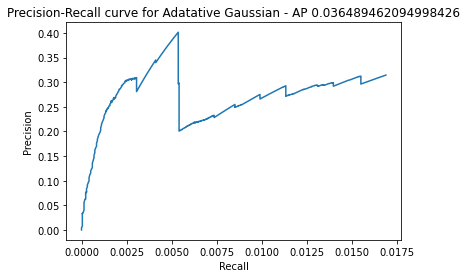

In [8]:
recs, precs, aps = ap_wo_conf(gt_detect,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian - AP {np.mean(aps)}')